In [1]:
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import h5py
from arts_preprocess_utils import load_dataset
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import scipy
#from scipy.spatial.distance import directed_hausdorff, cosine
from IPython import display

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    s = K.get_session()
    return s

In [3]:
reset_tf_session()

## Load dataset

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset('/root/work/datasets/wikiart_mini_ic.h5')

In [5]:
img_Height = train_set_x_orig.shape[1]
img_Width = train_set_x_orig.shape[2]
N_CLASSES = len(np.unique(test_set_y_orig))-1

In [6]:
X_train = train_set_x_orig * (1./255)
y_train = train_set_y_orig * (1./255)

X_dev = test_set_x_orig * (1./255)
y_dev = test_set_y_orig * (1./255)

**Plot image**

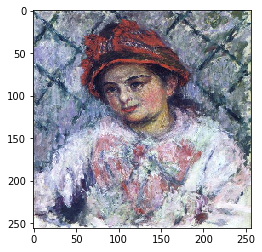

In [7]:
plt.imshow(X_dev[5][...,::-1])

## Autoencoder

**Helper functions to implement Sliced-Wassertein Autoencoder**

In [8]:
from models import Generator_model_complex, Discriminator_model

def build_deep_autoencoder(img_shape, code_size, filters = 40):
    
    encoder_model = Discriminator_model(filters=filters, code_shape=code_size, include_top=False)
    encoder = encoder_model.get_model(img_shape, N_CLASSES, False)
    
    decoder_model = Generator_model_complex(filters=filters, code_shape= (1,1,code_size))
    decoder = decoder_model.get_model(img_shape)
    
    return encoder, decoder

In [9]:
encoder, decoder = build_deep_autoencoder((img_Height, img_Width, 3), 100)

In [10]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 40)      1960      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 40)      160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 40)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 80)        51280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 80)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 160)       2

#### Build Sliced-Wasserstein Autoencoder

In [ ]:
#Set the global variables
l= 50
batch_size = 20
code_shape = (1,1,100)

In [ ]:
from wassertstein_utils import generateTheta, generateZ

theta = K.variable(generateTheta(l, code_shape))
z = K.variable(generateZ(batch_size, code_shape))

In [ ]:
import keras.layers as L
from keras.models import Model

img = L.Input((img_Height,img_Width,3)) #Input image
code = encoder(img)
reconstruction = decoder(code)

autoencoder = Model(inputs=img, outputs=reconstruction)

In [ ]:
autoencoder.summary()

**Sliced-Wasserstein loss function**

In [ ]:
from wassertstein_utils import sliced_wasserstein

vae_Loss = sliced_wasserstein(theta, z, img=img, reconstruction=reconstruction, code=code, batch_size=batch_size)
#Add loss function to autoencoder
autoencoder.add_loss(vae_Loss)

In [ ]:
autoencoder.compile(optimizer='rmsprop', loss='')

### Train model

**Sliced-Wasserstein autoencoder**

In [ ]:
loss_hist = []
for epoch in range(400):
    ind = np.random.permutation(X_train.shape[0])
    for i in range(int(X_train.shape[0]/batch_size)):
        imgs = X_train[ind[i*batch_size: (i+1)*batch_size],...]
        theta_ = generateTheta(l, code_shape)
        z_ = generateZ(batch_size, code_shape)
        K.set_value(z, z_)
        K.set_value(theta, theta_)
        loss = autoencoder.train_on_batch(x=imgs, y=None)
        loss_hist.append(loss)
    display.clear_output(wait=True)
    plt.plot(np.asarray(loss_hist))
    


**Denoising autoencoder**

In [19]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model

img = Input((img_Height,img_Width,3)) #Input image
code = encoder(img)
reconstruction = decoder(code)

autoencoder = Model(inputs=img, outputs=reconstruction)

In [20]:
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [ ]:
X_train_noisy = X_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_dev_noisy = X_dev + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=X_dev.shape)

In [ ]:
autoencoder.fit(x=X_train_noisy,y=X_train,
                epochs=128,
                batch_size=64,
                shuffle=True, 
                validation_data=(X_dev_noisy, X_dev))

**Save weights**

In [ ]:
encoder.save_weights('wasserstein_encoder01.h5')

In [ ]:
decoder.save_weights('wasserstein_decoder01.h5')

**Test autoencoder**

In [ ]:
code = encoder.predict(X_train[0:10])

In [ ]:
code.shape

In [ ]:
plt.imshow(code.reshape([code[6].shape[-1]//2,-1]))

In [ ]:
reconstructed = decoder.predict(code)

In [ ]:
plt.imshow(reconstructed[6][...,::-1])

In [ ]:
plt.imshow(np.clip(X_train_noisy[4], 0, 1)[...,::-1])

In [ ]:
plt.imshow(X_train[6][...,::-1])

**Encode random image**

In [ ]:
img = plt.imread('./Bren.jpg')

In [ ]:
img = cv2.resize(img, (img_Height, img_Width), interpolation=cv2.INTER_CUBIC)
img_norm = img *(1./255)
img_norm = np.expand_dims(img_norm, axis=0)

In [ ]:
plt.imshow(img_norm[0])

In [ ]:
code = encoder.predict(img_norm)
reconstructed = decoder.predict(code)

In [ ]:
plt.imshow(reconstructed[0])

In [ ]:
reconstructed = decoder.predict(np.random.uniform(0, 1, size=[10, 1, 1, 100]))